In [1]:
%autoreload 2

In [2]:
from argparse import Namespace
from collections import defaultdict
import copy
from datetime import datetime
import difflib
import gzip
import itertools
import os
import pickle
import sys
import typing

from IPython.display import display, Markdown, HTML
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import swifter
import sklearn
from sklearn.model_selection import GridSearchCV, train_test_split, KFold
from sklearn.pipeline import Pipeline
import tatsu
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import tqdm.notebook as tqdm


sys.path.append(os.path.abspath('..'))
sys.path.append(os.path.abspath('../src'))
from src import fitness_energy_utils as utils
from src.fitness_energy_utils import NON_FEATURE_COLUMNS
from src.ast_counter_sampler import *
from src.ast_utils import cached_load_and_parse_games_from_file, load_games_from_file, _extract_game_id
from src import ast_printer

In [3]:
grammar = open('../dsl/dsl.ebnf').read()
grammar_parser = tatsu.compile(grammar)
game_asts = list(cached_load_and_parse_games_from_file('../dsl/interactive-beta.pddl', grammar_parser, False, relative_path='..'))
# real_game_texts = [ast_printer.ast_to_string(ast, '\n') for ast in game_asts]
# regrown_game_texts = list(load_games_from_file('../dsl/ast-real-regrowth-samples.pddl'))


In [4]:
fitness_df = utils.load_fitness_data('../data/fitness_features_1024_regrowths.csv.gz')
print(fitness_df.src_file.unique())
print(fitness_df.shape)
fitness_df.head()

['interactive-beta.pddl' 'ast-real-regrowth-samples-1024.pddl']
(100450, 557)


,Index,src_file,game_name,domain_name,real,original_game_name,all_variables_defined,all_variables_used,all_preferences_used,setup_objects_used,...,ast_ngram_constraints_n_6_score,ast_ngram_constraints_n_7_score,ast_ngram_terminal_n_2_score,ast_ngram_terminal_n_3_score,ast_ngram_terminal_n_4_score,ast_ngram_terminal_n_5_score,ast_ngram_scoring_n_2_score,ast_ngram_scoring_n_3_score,ast_ngram_scoring_n_4_score,ast_ngram_scoring_n_5_score
0,0,interactive-beta.pddl,6172feb1665491d1efbce164-0,medium-objects-room-v1,1,6172feb1665491d1efbce164-0,1,1,1,1.00,...,0.980067,0.986492,0.969939,0.953334,0.953763,1.0,0.976732,1.000000,NaN,NaN
1,1,interactive-beta.pddl,5f77754ba932fb2c4ba181d8-2,many-objects-room-v1,1,5f77754ba932fb2c4ba181d8-2,1,1,1,1.00,...,0.986147,0.984360,0.979472,0.963387,0.956034,1.0,0.920877,0.912831,0.950209,0.971266
2,2,interactive-beta.pddl,614b603d4da88384282967a7-3,many-objects-room-v1,1,614b603d4da88384282967a7-3,1,1,1,0.00,...,0.987902,0.983477,NaN,NaN,NaN,NaN,0.900347,0.950613,1.000000,NaN
3,3,interactive-beta.pddl,5bc79f652885710001a0e82a-5,few-objects-room-v1,1,5bc79f652885710001a0e82a-5,1,1,1,0.00,...,0.988000,0.985901,NaN,NaN,NaN,NaN,0.976732,1.000000,NaN,NaN
4,4,interactive-beta.pddl,614dec67f6eb129c3a77defd-6,medium-objects-room-v1,1,614dec67f6eb129c3a77defd-6,1,1,1,0.25,...,0.987393,0.984222,NaN,NaN,NaN,NaN,0.965546,0.946326,0.964174,0.979002


In [5]:
POSITIVES_FILE = 'interactive-beta.pddl'
NEGATIVES_FILE = 'ast-real-regrowth-samples-1024.pddl'

def create_filtered_df(df: pd.DataFrame, 
    filter_data_src_files: typing.Sequence[str] = (POSITIVES_FILE, NEGATIVES_FILE),
    ) -> pd.DataFrame:
    f_df = fitness_df[fitness_df.src_file.isin(filter_data_src_files)].reset_index(drop=True)
    f_df.loc[f_df.src_file == filter_data_src_files[0], 'real'] = 1
    return f_df

filtered_fitness_df = create_filtered_df(fitness_df)

In [7]:
print(filtered_fitness_df.shape)
filtered_fitness_df.head()

(100450, 578)


,Index,src_file,game_name,ast_ngram_n_7_8,ast_ngram_n_7_6,ast_ngram_n_7_7,ast_ngram_n_7_9,domain_name,real,original_game_name,...,ast_ngram_n_6_6,ast_ngram_n_6_7,ast_ngram_n_6_8,ast_ngram_n_6_9,ast_ngram_n_7_0,ast_ngram_n_7_1,ast_ngram_n_7_2,ast_ngram_n_7_3,ast_ngram_n_7_4,ast_ngram_n_7_5
0,0,interactive-beta.pddl,6172feb1665491d1efbce164-0,0,0,0,0,medium-objects-room-v1,1,6172feb1665491d1efbce164-0,...,1,0,0,0,0,0,1,1,0,0
1,1,interactive-beta.pddl,5f77754ba932fb2c4ba181d8-2,1,1,1,0,many-objects-room-v1,1,5f77754ba932fb2c4ba181d8-2,...,0,0,1,1,1,1,0,0,1,1
2,2,interactive-beta.pddl,614b603d4da88384282967a7-3,0,0,0,0,many-objects-room-v1,1,614b603d4da88384282967a7-3,...,0,0,0,0,0,0,0,0,0,0
3,3,interactive-beta.pddl,5bc79f652885710001a0e82a-5,1,1,1,0,few-objects-room-v1,1,5bc79f652885710001a0e82a-5,...,1,0,1,1,1,1,1,1,1,1
4,4,interactive-beta.pddl,614dec67f6eb129c3a77defd-6,1,1,1,0,medium-objects-room-v1,1,614dec67f6eb129c3a77defd-6,...,1,0,1,1,1,1,1,1,1,1


In [7]:
fake_games = filtered_fitness_df[filtered_fitness_df.src_file == NEGATIVES_FILE].reset_index()
broadcasted_original = filtered_fitness_df.loc[[filtered_fitness_df.index[(filtered_fitness_df.game_name == original_name)][0] for original_name in fake_games.original_game_name], :].reset_index()

original_regrown_diffs = (broadcasted_original.drop(NON_FEATURE_COLUMNS, axis=1) - fake_games.drop(NON_FEATURE_COLUMNS, axis=1))

unchanged_games_prop = (original_regrown_diffs.drop('index', axis=1) == 0).all(axis=1).sum() / len(original_regrown_diffs)
print(f'In {unchanged_games_prop * 100:.2f}% of the games, the regrown game was identical to the original game.')

In 1.70% of the games, the regrown game was identical to the original game.


In [8]:
never_change = (original_regrown_diffs.drop('index', axis=1) == 0).all(axis=0)
for x in never_change.index[never_change]:
    print(x)

print(sum(never_change))

length_of_then_modals_7
max_number_variables_types_quantified_types_6
max_number_variables_types_quantified_types_8
max_number_variables_types_quantified_variables_7
compositionality_structure_9
max_depth_setup_0
max_depth_terminal_0
mean_depth_setup_0
mean_depth_terminal_0
node_count_setup_0
node_count_terminal_0
node_count_terminal_1
12


# Synthetic model-fitting experiment approach
We have a large dataset now, I can try to cross-validate over some of the choices I might make:
* Change the random seed?
* See if the GPU is faster
* Try a different from of regularization?



['ast_ngram_n_7_score']
Train tensor shape: torch.Size([78, 1025, 567]) | Test tensor shape: torch.Size([20, 1025, 567])
Fitting 5 folds for each of 8 candidates, totalling 40 fits


### Test results:

{'ecdf': -0.09529756097560978, 'game_rank': 0.96923828125}

### CV results by overall ECDF:

,fitness__batch_size,fitness__k,fitness__loss_function,fitness__lr,fitness__margin,fitness__n_features,fitness__weight_decay,ecdf_mean,ecdf_std,ecdf_rank,game_rank_mean,game_rank_std,game_rank_rank
4,4,256,<function fitness_square_square_loss at 0x7fa6...,0.01,8,567,0.0,-0.139254,0.024917,1,0.962465,0.006449,5
2,2,512,<function fitness_square_square_loss at 0x7fa6...,0.01,8,567,0.0,-0.143578,0.019575,2,0.963879,0.005844,2
6,4,512,<function fitness_square_square_loss at 0x7fa6...,0.01,8,567,0.0,-0.143862,0.025512,3,0.963785,0.006887,3
0,2,256,<function fitness_square_square_loss at 0x7fa6...,0.01,8,567,0.0,-0.145957,0.011546,4,0.965514,0.007497,1
3,2,512,<function fitness_square_square_loss at 0x7fa6...,0.01,16,567,0.0,-0.146189,0.021368,5,0.961912,0.005919,7
7,4,512,<function fitness_square_square_loss at 0x7fa6...,0.01,16,567,0.0,-0.147803,0.019084,6,0.962160,0.007148,6
5,4,256,<function fitness_square_square_loss at 0x7fa6...,0.01,16,567,0.0,-0.156231,0.034408,7,0.963273,0.005425,4
1,2,256,<function fitness_square_square_loss at 0x7fa6...,0.01,16,567,0.0,-0.169669,0.027425,8,0.954972,0.012638,8


### CV results by mean single game rank:

,fitness__batch_size,fitness__k,fitness__loss_function,fitness__lr,fitness__margin,fitness__n_features,fitness__weight_decay,ecdf_mean,ecdf_std,ecdf_rank,game_rank_mean,game_rank_std,game_rank_rank
0,2,256,<function fitness_square_square_loss at 0x7fa6...,0.01,8,567,0.0,-0.145957,0.011546,4,0.965514,0.007497,1
2,2,512,<function fitness_square_square_loss at 0x7fa6...,0.01,8,567,0.0,-0.143578,0.019575,2,0.963879,0.005844,2
6,4,512,<function fitness_square_square_loss at 0x7fa6...,0.01,8,567,0.0,-0.143862,0.025512,3,0.963785,0.006887,3
5,4,256,<function fitness_square_square_loss at 0x7fa6...,0.01,16,567,0.0,-0.156231,0.034408,7,0.963273,0.005425,4
4,4,256,<function fitness_square_square_loss at 0x7fa6...,0.01,8,567,0.0,-0.139254,0.024917,1,0.962465,0.006449,5
7,4,512,<function fitness_square_square_loss at 0x7fa6...,0.01,16,567,0.0,-0.147803,0.019084,6,0.962160,0.007148,6
3,2,512,<function fitness_square_square_loss at 0x7fa6...,0.01,16,567,0.0,-0.146189,0.021368,5,0.961912,0.005919,7
1,2,256,<function fitness_square_square_loss at 0x7fa6...,0.01,16,567,0.0,-0.169669,0.027425,8,0.954972,0.012638,8


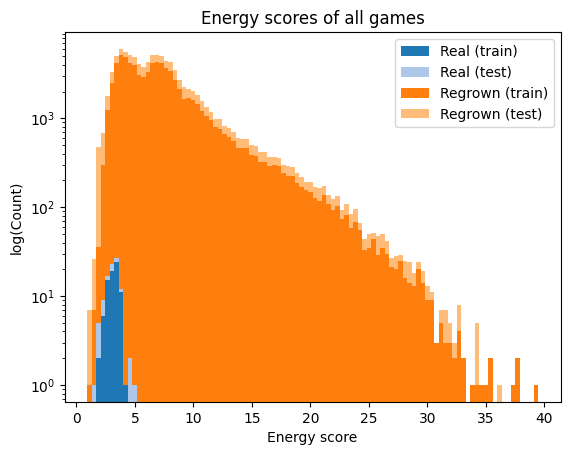

0.13775718 0.5275108 2.6936138


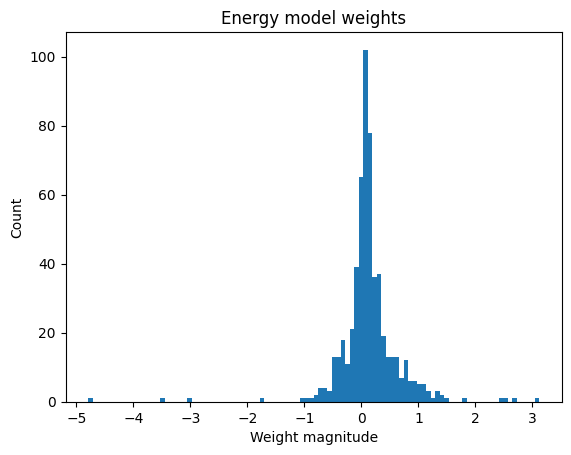

In [42]:
# test_param_grid = [
#     {
#         'fitness__loss_function': [utils.fitness_square_square_loss], # [utils.fitness_hinge_loss_with_cross_example],
#         'fitness__weight_decay': [0.0, 0.1, 0.25],  
#         'fitness__margin': [1, 2, 4, 8],
#         # 'fitness__beta': [0.25, 1, 2, 4],
#         'fitness__lr':  [1e-1, 3e-2, 1e-2, 3e-3],  # [1e-1, 3e-2, 1e-2, 3e-3],
#         'fitness__k': [16, 32, 64],  # 128
#         'fitness__batch_size': [2, 4, 8, 16],  # [1, 4, 8, 16],
#         # 'fitness__alpha': [0, 0.25, 0.5, 0.75, 1], # [0, 0.1, 0.2, 0.3],  #
#         # 'fitness__dataset_energy_beta': [1, 3, 5],
#     },
# ]
test_param_grid = [
    {
        'fitness__loss_function': [utils.fitness_square_square_loss], # [utils.fitness_hinge_loss_with_cross_example],
        'fitness__weight_decay': [0.0],  
        'fitness__margin': [8, 16],
        # 'fitness__beta': [0.25, 1, 2, 4],
        'fitness__lr':  [1e-2],  # [1e-1, 3e-2, 1e-2, 3e-3],
        'fitness__k': [256, 512],  # 128
        'fitness__batch_size': [2, 4],  # [1, 4, 8, 16],
        # 'fitness__alpha': [0, 0.25, 0.5, 0.75, 1], # [0, 0.1, 0.2, 0.3],  #
        # 'fitness__dataset_energy_beta': [1, 3, 5],
        # 'fitness__regularization_weight': [0.01, 0.05],
    },
]

def build_regularization_function(ord: int = 1, threshold: float = 0):
    def regularization_function(model: nn.Module) -> torch.Tensor:
        w = model.fc1.weight.squeeze()  # type: ignore
        return torch.linalg.norm(w * (w.abs() >= threshold), ord)
    
    return regularization_function

regularizer = build_regularization_function(ord=1, threshold=0)

scaler_kwargs = dict(passthrough=True)
model_kwargs = dict(output_activation=nn.Identity())
train_kwargs = dict(negative_score_reduction='none', n_epochs=3000, patience_epochs=10, 
    shuffle_negatives=True, device=torch.device('cuda:0'), 
    # regularizer=regularizer
    )
cv_kwargs = dict(refit='overall_ecdf', error_score='raise')  # , n_jobs=1)
scoring = utils.build_multiple_scoring_function(
    [utils.evaluate_fitness_overall_ecdf, utils.evaluate_fitness_single_game_rank],
    ['overall_ecdf', 'single_game_rank'],
)

feature_columns = [str(c) for c in fitness_df.columns if c not in NON_FEATURE_COLUMNS]
for n in range(2, 7):
    feature_columns.remove(f'ast_ngram_n_{n}_score')
print([c for c in feature_columns if 'score' in c])

cv, (train_tensor, test_tensor), test_results = utils.model_fitting_experiment(
    # [fitness_df, mle_samples_df], 
    fitness_df, 
    test_param_grid, feature_columns=feature_columns,
    scoring_function=scoring, verbose=1, scaler_kwargs=scaler_kwargs, 
    model_kwargs=model_kwargs, train_kwargs=train_kwargs, cv_kwargs=cv_kwargs,
    energy_weighted_resampling=True, 
    # random_seed=42,
    )

utils.visualize_cv_outputs(cv, train_tensor, test_tensor, test_results)

In [15]:
cv.best_estimator_.named_steps['fitness'].model.fc1.weight.shape

torch.Size([1, 567])

In [23]:
w = cv.best_estimator_.named_steps['fitness'].model.fc1.weight.squeeze()
z = w * (w > 1e-3)
torch.linalg.norm(z, 0)

tensor(407., grad_fn=<LinalgVectorNormBackward0>)

In [ ]:
filtered_df = create_filtered_df(fitness_df)
feature_columns = [c for c in filtered_df.columns if c not in NON_FEATURE_COLUMNS]
full_tensor = utils.df_to_tensor(filtered_df, feature_columns)

In [43]:
# cv.best_estimator_.fit(full_tensor)
SAVE_MODEL = True
if SAVE_MODEL:
    output_path = f'../models/cv_fitness_model_{datetime.now().strftime("%Y_%m_%d")}.pkl.gz'
    original_output_path = output_path[:]
    i = 0
    while os.path.exists(output_path):
        output_path = original_output_path + f'_{i}'
        i += 1

    with gzip.open(output_path, 'wb') as f:
        pickle.dump(cv.best_estimator_, f, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
test_param_grid = [
    {
        'fitness__loss_function': [utils.fitness_square_square_loss], # [utils.fitness_hinge_loss_with_cross_example],
        'fitness__weight_decay': [0.0, 0.25, 1, 2],  
        'fitness__margin': [1, 2, 4, 8],
        # 'fitness__beta': [0.25, 1, 2, 4],
        'fitness__lr':  [1e-1, 3e-2, 1e-2, 3e-3],  # [1e-1, 3e-2, 1e-2, 3e-3],
        'fitness__k': [4, 8, 16, 32, 64],
        'fitness__batch_size': [2, 4, 8, 16],  # [1, 4, 8, 16],
        # 'fitness__alpha': [0, 0.25, 0.5, 0.75, 1], # [0, 0.1, 0.2, 0.3],  #
        'fitness__dataset_energy_beta': [1, 3, 5],
    },
]


cv_with_resampling, (train_tensor_with_resampling, test_tensor_with_resampling), test_results_with_resampling = utils.model_fitting_experiment(
    # [fitness_df, mle_samples_df], 
    fitness_df, 
    test_param_grid,
    scoring_function=scoring, verbose=1, scaler_kwargs=scaler_kwargs, 
    model_kwargs=model_kwargs, train_kwargs=train_kwargs, cv_kwargs=cv_kwargs,
    energy_weighted_resampling=True
    )


utils.visualize_cv_outputs(cv_with_resampling, train_tensor_with_resampling, test_tensor_with_resampling, test_results_with_resampling, histogram_title_note='energy weighted resampling')

### Checking the effect of regrowth depth

In [ ]:
feature_columns = [c for c in binarized_df.columns if c not in NON_FEATURE_COLUMNS]
full_binarized_tensor = utils.df_to_tensor(binarized_df, feature_columns)
full_tensor_scores = cv_no_scaling_sq_sq.best_estimator_.transform(full_binarized_tensor).detach()

In [ ]:
energy_diffs = full_tensor_scores[:, 1:] - full_tensor_scores[:, 0].unsqueeze(1)
energy_diffs.ravel().shape

In [ ]:
def extract_regrowth_depth(game_text: str):
    game_id_start = game_text.find('(game')
    game_id_section = game_text[game_id_start:game_text.find(')', game_id_start)]
    regrowth_depth = game_id_section[game_id_section.rfind('-') + 2:]
    return int(regrowth_depth)

regrowth_depts = [extract_regrowth_depth(g) for g in regrown_game_texts]

In [ ]:
plt.scatter(regrowth_depts, energy_diffs.ravel().numpy(), s=5)

In [ ]:
map_samples_fitness_df = utils.load_fitness_data('../data/ast_mle_fitness_scores.csv')
binarized_map_samples_fitness_df = binarize_features(map_samples_fitness_df)

map_samples_binarized_arr = binarized_map_samples_fitness_df.loc[:, [c for c in binarized_map_samples_fitness_df.columns if c not in NON_FEATURE_COLUMNS]]
map_samples_binarized_tensor = torch.from_numpy(map_samples_binarized_arr.values).float()

map_samples_binarized_energies = cv_no_scaling_sq_sq.best_estimator_.transform(map_samples_binarized_tensor.unsqueeze(1)).squeeze()

In [ ]:
histogram_log_y = True
histogram_title_base = 'Binarized features with MAP games, square-square loss'

train_positive_scores = cv_no_scaling_sq_sq.best_estimator_.transform(train_tensor_no_scaling_sq_sq[:, 0, :]).detach().squeeze().numpy()  # type: ignore
test_positive_scores = cv_no_scaling_sq_sq.best_estimator_.transform(test_tensor_no_scaling_sq_sq[:, 0, :]).detach().squeeze().numpy()  # type: ignore
train_negative_scores = cv_no_scaling_sq_sq.best_estimator_.transform(train_tensor_no_scaling_sq_sq[:, 1:, :]).detach().squeeze().numpy()  # type: ignore
test_negative_scores = cv_no_scaling_sq_sq.best_estimator_.transform(test_tensor_no_scaling_sq_sq[:, 1:, :]).detach().squeeze().numpy()  # type: ignore

hist_scores = [train_positive_scores, test_positive_scores, 
               train_negative_scores.flatten(), test_negative_scores.flatten(),
               map_samples_binarized_energies.detach().numpy()] 

labels = ['Real (train)', 'Real (test)', 'Negatives (train)', 'Negatives (test)', 'MAP samples']

cm = plt.get_cmap('tab20')  # type: ignore
colors = cm.colors[:5]

plt.hist(hist_scores, label=labels, stacked=True, bins=100, color=colors)  # type: ignore
plt.title(histogram_title_base)

plt.xlabel('Energy score')

if histogram_log_y:
    plt.ylabel('log(Count)')
    plt.semilogy()
else:
    plt.ylabel('Count')

plt.legend(loc='best')
plt.show()

In [ ]:
weight_threshold = 1
weights = cv_no_scaling_sq_sq.best_estimator_.named_steps['fitness'].model.fc1.weight.data.detach().squeeze()  # type: ignore
weights_above_threshold = (weights.abs() > weight_threshold).numpy()
feature_columns = [c for c in binarized_map_samples_fitness_df.columns if c not in NON_FEATURE_COLUMNS]
features_with_weight_above_threshold = [feature_columns[i] for i in range(len(feature_columns)) if weights_above_threshold[i]]

with open('../data/features_with_weight_above_threshold_2022_01_24.txt', 'w') as f:
    f.write('\n'.join(features_with_weight_above_threshold))
    


In [ ]:
full_binarized_tensor = utils.df_to_tensor(binarized_df, [c for c in binarized_df.columns if c not in NON_FEATURE_COLUMNS])
test_negative_scores_tensor = torch.tensor(test_negative_scores)
test_positive_scores_tensor = torch.tensor(test_positive_scores)
feature_columns = [c for c in binarized_df.columns if c not in NON_FEATURE_COLUMNS]

In [ ]:
torch.topk((test_negative_scores_tensor - test_positive_scores_tensor.unsqueeze(-1)).ravel(), 30, largest=False)

In [ ]:
test_negative_scores_tensor.ravel()[836] == test_negative_scores_tensor[836 // 64, 836 % 64]

In [ ]:
utils.evaluate_energy_contributions(
    cv_no_scaling_sq_sq, test_tensor_no_scaling_sq_sq, 1036,
    feature_columns, full_binarized_tensor, real_game_texts, regrown_game_texts,
)

In [34]:
fitness_df.columns

Index(['Index', 'src_file', 'game_name', 'domain_name', 'real',
       'original_game_name', 'all_variables_defined', 'all_variables_used',
       'all_preferences_used', 'setup_objects_used',
       ...
       'ast_ngram_constraints_n_6_score', 'ast_ngram_constraints_n_7_score',
       'ast_ngram_terminal_n_2_score', 'ast_ngram_terminal_n_3_score',
       'ast_ngram_terminal_n_4_score', 'ast_ngram_terminal_n_5_score',
       'ast_ngram_scoring_n_2_score', 'ast_ngram_scoring_n_3_score',
       'ast_ngram_scoring_n_4_score', 'ast_ngram_scoring_n_5_score'],
      dtype='object', length=557)

In [35]:
# [c for c in fitness_df.columns if 'arg_types' in c]
fitness_df.columns.get_loc('ast_ngram_constraints_n_6_score')

547

In [36]:
from argparse import Namespace
from src.fitness_features import *
# from src.fitness_ngram_models import TextNGramModel, TextMultiNGramModel, ASTMultiNGramModel, NGramASTParser

# with gzip.open('../models/fitness_featurizer_2023_02_02.pkl.gz', 'rb') as f:
#     featurizer = pickle.load(f)


In [37]:
args = Namespace(no_binarize=False, no_merge=False)
featurizer = build_fitness_featurizer(args)

In [17]:
np.seterr(all='raise')
_ = [featurizer.parse(game_asts[i], 'interactive-beta.pddl', return_row=False) for i in range(len(game_asts))]
# _ = [featurizer.parse(game_asts[74], 'interactive-beta.pddl', return_row=False) for _ in range(1000)]

In [44]:
d = featurizer.to_df()

2023-03-01 15:54:54 INFO     No features to merge for prefix adjacent_arg_types and suffix setup
2023-03-01 15:54:54 INFO     No features to merge for prefix adjacent_side_3_arg_types and suffix setup
2023-03-01 15:54:54 INFO     No features found for prefix agent_holds_arg_types and suffix setup
2023-03-01 15:54:54 INFO     No features to merge for prefix between_arg_types and suffix setup
2023-03-01 15:54:54 INFO     No features to merge for prefix distance_arg_types and suffix setup
2023-03-01 15:54:54 INFO     No features to merge for prefix in_arg_types and suffix setup
2023-03-01 15:54:54 INFO     No features found for prefix in_motion_arg_types and suffix setup
2023-03-01 15:54:54 INFO     No features to merge for prefix object_orientation_arg_types and suffix setup
2023-03-01 15:54:54 INFO     No features to merge for prefix on_arg_types and suffix setup
2023-03-01 15:54:54 INFO     No features found for prefix touch_arg_types and suffix setup
2023-03-01 15:54:54 INFO     No fe

In [39]:
np.seterr(all='raise')
%prun _ = [featurizer.parse(game_asts[i], 'interactive-beta.pddl', return_row=False) for i in range(len(game_asts))]
# _ = [featurizer.parse(game_asts[74], 'interactive-beta.pddl', return_row=False) for _ in range(1000)]

         5009856 function calls (4655734 primitive calls) in 2.690 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
    99773    0.235    0.000    0.328    0.000 fitness_ngram_models.py:183(_score_ngram)
88682/5132    0.152    0.000    1.412    0.000 ast_parser.py:32(__call__)
 22090/98    0.139    0.000    1.727    0.018 fitness_features.py:287(_parse)
    15311    0.121    0.000    0.270    0.000 ast_printer.py:556(_handle_predicate)
   310571    0.117    0.000    0.148    0.000 ast.py:58(__getitem__)
   138682    0.101    0.000    0.101    0.000 ast.py:92(__hasattribute__)
61770/8125    0.100    0.000    1.021    0.000 ast_printer.py:215(wrapper_func)
56528/8125    0.087    0.000    1.043    0.000 ast_printer.py:95(_handle_ast)
   137782    0.082    0.000    0.288    0.000 ast.py:80(__getattr__)
   755722    0.077    0.000    0.079    0.000 {built-in method builtins.isinstance}
   200284    0.067    0.000    0.067    0.00

In [10]:
from src.fitness_ngram_models import *

In [11]:
with open('../models/ast_7_ngram_model_2023_02_27.pkl', 'rb') as f:
    n_gram_model = pickle.load(f)

In [21]:
root = n_gram_model.model.root
tree = n_gram_model.model.tree
frontier = [(root, tuple())]

while frontier:
    node, path = frontier.pop()
    if len(path) > 0:
        node_count = node.count
        tree_count = tree[path]
        if node_count != tree_count:
            print(f'Path: {path}, node count: {node_count}, tree count: {tree_count}')
            
    for key in node.children.keys():
        frontier.append((node.children[key], path + (key,)))

In [19]:
n_gram_model.model.get(('setup', 'setup_and'))

58

In [20]:
n_gram_model.model.tree[('setup', 'setup_and')]

58

In [40]:
d = featurizer.to_df()

In [ ]:
(d == d.loc[0]).all(axis=1).all()

In [41]:
d[[c for c in d.columns if 'ast_ngram_terminal' in c]].head()

,ast_ngram_terminal_n_2_score,ast_ngram_terminal_n_3_score,ast_ngram_terminal_n_4_score,ast_ngram_terminal_n_5_score
0,0.822108,0.718108,0.512996,1.0
1,0.878520,0.778834,0.536918,1.0
2,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN


<AxesSubplot: >

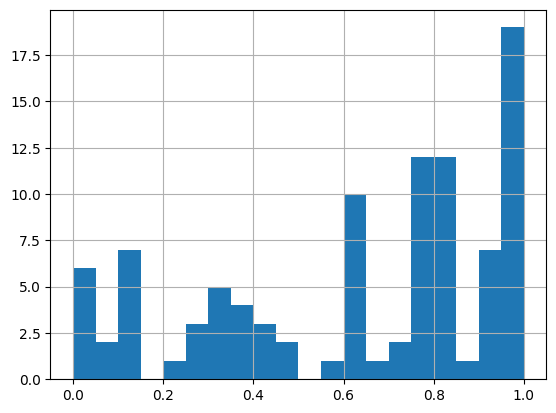

In [27]:
d.ast_ngram_setup_n_5_score.hist(bins=20)

In [ ]:
(d[[c for c in d.columns if 'ast_ngram' in c]] == 1).sum()

In [ ]:
np.where(d.no_adjacent_same_modal == -1)

In [ ]:
d.game_name[np.where(d.no_adjacent_same_modal == -1)[0]]

In [ ]:
[c for c in d.columns if 'ast_ngram' in c]

In [ ]:
d.index[d.redundant_expression_found != 0]

In [ ]:
d.loc[56, :]

In [ ]:
t = regrown_game_texts[631]
a = grammar_parser.parse(t)
r = featurizer.parse(a, '', True)

In [26]:
p = train_tensor[:, 0, :]
n = train_tensor[:, 1:, :]
print(p.shape, n.shape)
perm = torch.randperm(n.shape[0] * n.shape[1])
n_new = n.reshape(-1, n.shape[2])[perm, :].reshape(n.shape[0], n.shape[1], n.shape[2])
print(p.shape, n.shape)

torch.Size([78, 1562]) torch.Size([78, 1024, 1562])
torch.Size([78, 1562]) torch.Size([78, 1024, 1562])


In [4]:
import numpy as np
rng = np.random.default_rng(0)

In [7]:
rng.choice(['a', 'b', 'c'], p=[1, 2, 3])

ValueError: probabilities do not sum to 1